In [1]:
import time
import matplotlib.pyplot as plt
import torch

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.points_renderer import PointsRenderer
from src.render.pulsar_renderer import PulsarRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
from src.util import grid_to_list

In [2]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 1
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 256
config.data_blueprint = 'blueprint_radial_2048.npz'
config.data_blueprint_size = 2048
config.data_patch_size = 1000
blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
#faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([1, 1000000, 3]),
 torch.Size([1, 1000000, 3]),
 torch.Size([1, 1996002, 3]))

In [3]:
config.data_blueprint

'blueprint_radial_2048.npz'

In [4]:
R = PointsRenderer(config)
R.setup(device)
R = R.to(device)

1.2897546291351318


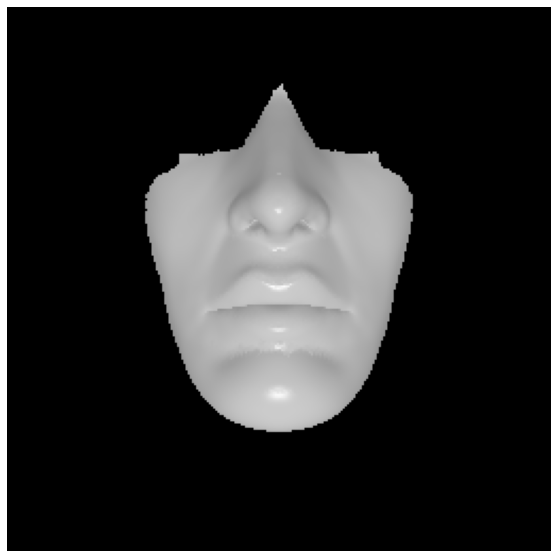

In [5]:
start_time = time.time()
images = R(points, normals=normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [6]:
cal_normals = R.get_vertex_normals(points)
cal_normals

ModuleAttributeError: 'PointsRenderer' object has no attribute 'get_vertex_normals'

0.09325838088989258


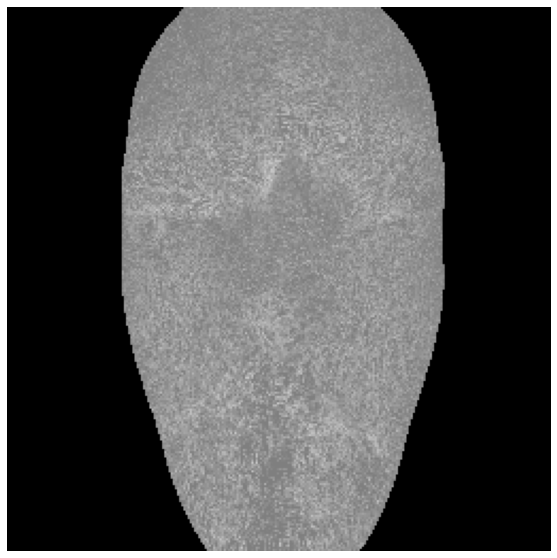

In [13]:
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

0.08612370491027832


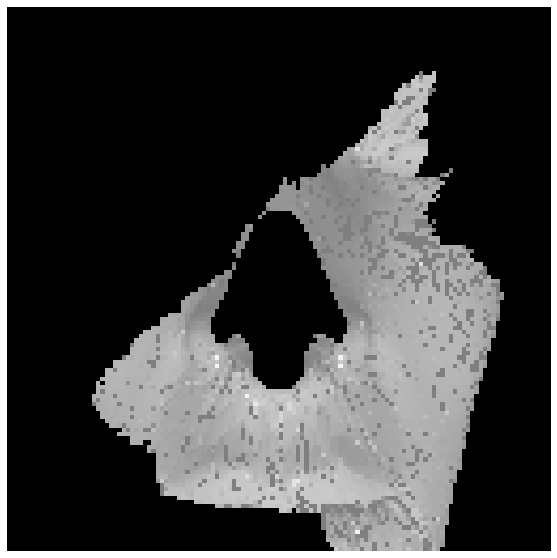

In [17]:
start_time = time.time()
images = M(points, faces)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [ ]:
P = PulsarRenderer(config)
P.setup(device)

0.03096461296081543


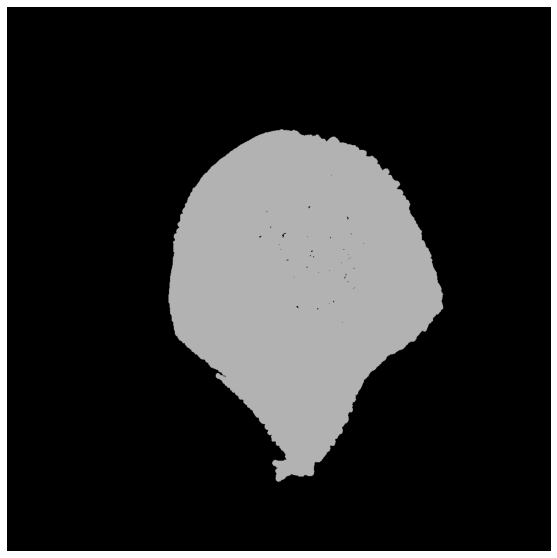

In [42]:
start_time = time.time()
images = P(points)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [27]:
config.data_patch_size,  config.raster_image_size

(256, 128)

In [19]:
opt = config

R, T = look_at_view_transform(
    opt.viewpoint_distance, 
    opt.viewpoint_elevation, 
    opt.viewpoint_azimuth, 
    device=device)
cameras = FoVPerspectiveCameras(
    device=device, R=R, T=T)
raster_settings = RasterizationSettings(
    image_size= opt.raster_image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1,
)
rasterizer= MeshRasterizer(
    cameras=cameras, 
    raster_settings=raster_settings
)        
lights = PointLights(device=device, 
                     location=[opt.lights_location])
shader = SoftPhongShader(
    device=device, 
    cameras=cameras,
    lights=lights
)        
self.renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=shader
)     

TypeError: __init__() got an unexpected keyword argument 'rasterizer'